In [55]:
import collections
import os
import pickle
import numpy as np
import gym
import driving_envs
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [45]:
# A Dict[run_name, List[run save data per participant]]
# save data is a Dict[phase A/B, List[episodes]] where each
# episode is a List[Tuple(state, reward, done)]
eval_data = collections.defaultdict(list)
for folder_name in os.listdir("eval_data"):
    ind_path = os.path.join("eval_data", folder_name)
    for run_name in os.listdir(ind_path):
        run_id, _ = os.path.splitext(run_name)
        run_path = os.path.join(ind_path, run_name)
        with open(run_path, "rb") as f:
            eval_data[run_id].append(pickle.load(f))

In [46]:
run_to_method = {"run1": "Multi LSTM", "run2": "Multi FC", "run3": "Combined LSTM", "run4": "Combined FC"}

In [47]:
def get_return(ep):
    return sum([t[1] for t in ep])

In [90]:
rows = []
for run_name in eval_data:
    for save_data in eval_data[run_name]:
        for phase in save_data:
            # Only using the last 3 episdoe in each phase since the first two
            # were practice episodes>
            for episode in save_data[phase][2:]:
                ep_ret = get_return(episode)
                method = run_to_method[run_name]
                crashed = len(episode) != 60
                final_state = episode[-1][0]
                # Did the robot pass the human by the final timestep?
                passed = (final_state[1] < final_state[8]) and (final_state[7] < 60)
                rows.append([method, phase, ep_ret, crashed, passed])
assert len(rows) == 4 * 2 * 8 * 3  # num_runs * num_phases * num_ppl * num_episodes
df = pd.DataFrame(rows, columns=["Method", "Phase", "Return", "Crashed", "Passed"])

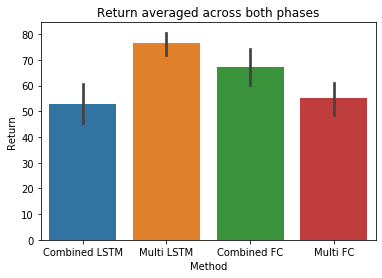

In [87]:
plt.title("Return averaged across both phases")
sns.barplot(data=df, x="Method", y="Return")

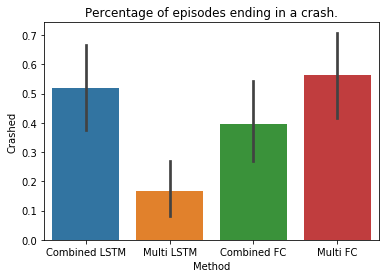

In [80]:
plt.title("Percentage of episodes ending in a crash.")
sns.barplot(data=df, x="Method", y="Crashed")

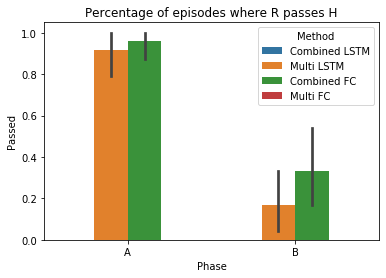

In [92]:
plt.title("Percentage of episodes where R passes H")
sns.barplot(data=df, x="Phase", y="Passed", hue="Method")